# Image Classification Using DeepLearning

We are going to use a technique called `Transfer Learning` in which we utilize an already trained network to help us in classifying in which the image is contains a rabbit or cats.

Let's get started!

In [1]:
# Dependencies
import warnings
warnings.filterwarnings('ignore')
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Dataset

For this project, we will use the `Cat vs Rabbit dataset`, which contains images of Cats and Rabbits.

Download the `training` and `validation` sets by running the cell below:

In [2]:
# Unzipping the zip files
train_local_zip = '/content/train-cat-rabbit.zip'
zip_ref = zipfile.ZipFile(train_local_zip, 'r')
zip_ref.extractall('train-cat-rabbit')

val_local_zip = '/content/val-cat-rabbit.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('val-cat-rabbit')

zip_ref.close()

This dataset already has an structure that is compatible with Keras' `flow_from_directory` so you don't need to move the images into subdirectories as you did in the previous assignments. However, it is still a good idea to save the paths of the images so you can use them later on:

In [3]:
# Directory with training Cats pictures
train_cats_dir = "/content/train-cat-rabbit/train-cat-rabbit/cat"
# Directory with training Rabbits pictures
train_rabbits_dir = "/content/train-cat-rabbit/train-cat-rabbit/rabbit"
# Directory with validation Cats pictures
validation_cats_dir = "/content/val-cat-rabbit/val-cat-rabbit/cat"
# Directory with validation Rabbits pictures
validation_rabbits_dir = "/content/val-cat-rabbit/val-cat-rabbit/rabbit"

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_cats_dir))} images of Cats for training.\n")
print(f"There are {len(os.listdir(train_rabbits_dir))} images of Rabbits for training.\n")
print(f"There are {len(os.listdir(validation_cats_dir))} images of Cats for validation.\n")
print(f"There are {len(os.listdir(validation_rabbits_dir))} images of Rabbits for validation.\n")

There are 800 images of Cats for training.

There are 800 images of Rabbits for training.

There are 207 images of Cats for validation.

There are 207 images of Rabbits for validation.



Now let us take a look at a sample image of each one of the classes:

Sample Cat image:


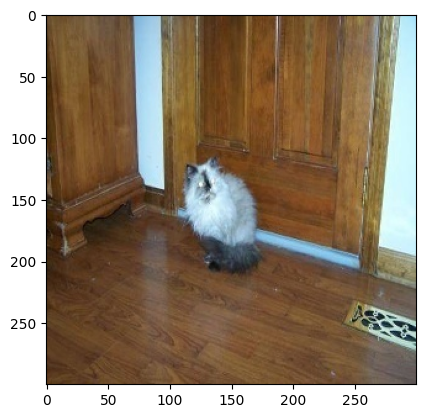


Sample Rabbit image:


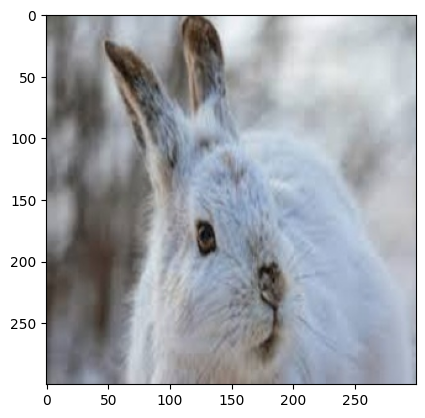

In [4]:
print("Sample Cat image:")
plt.imshow(load_img(f"{os.path.join((train_cats_dir), os.listdir(train_cats_dir)[0])}"))
plt.show()

print("\nSample Rabbit image:")
plt.imshow(load_img(f"{os.path.join((train_rabbits_dir), os.listdir(train_rabbits_dir)[0])}"))
plt.show()

In [5]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join((train_cats_dir), os.listdir(train_cats_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


## Training and Validation Generators

Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the `train_val_generators` function below:

**Important Note:** The images have a resolution of 300x300 but the `flow_from_directory` method you will use allows you to set a target resolution. In this case, **set a `target_size` of (150, 150)**. This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy!

In [6]:
TRAINING_DIR = '/content/train-cat-rabbit/train-cat-rabbit'
VALIDATION_DIR = '/content/val-cat-rabbit/val-cat-rabbit'

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=50,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.3,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen =  ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=50,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.3,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator


In [7]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 1600 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [8]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-11-08 12:15:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 173.194.79.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  25.0MB/s    in 3.5s    

2023-11-08 12:15:46 (23.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Now load the `InceptionV3` model and save the path to the weights you just downloaded:

In [9]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [10]:
# Creating the pre trained model
def create_pre_trained_model(local_weights_file, include_top=False):
  # Initialize the model
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = include_top,
                                  weights = None)

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable "Freezing Layers"
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

Check that everything went well by comparing the last few rows of the model summary to the expected output:

In [11]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

We Noticed that the number of the Non-trainable paramters is "21,802,784"

1. **Total params: 21802784 (83.17 MB)**

2. **Trainable params: 0 (0.00 Byte)**

3. **Non-trainable params: 21802784 (83.17 MB)**


## Building Callback

Now we will build the callback to stop training once an accuracy of 99.9% is reached.

In [12]:
#Defin e a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  # Build the method on_epoch_end()
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):

        print("\nReached 95.0% accuracy so cancelling training!")
        self.model.stop_training = True

## Pipelining the pre-trained model with your own

For this we will need the last output of the pre-trained model, since this will be the input for our own.

In [13]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output


The output should be like this: (batch_size, height, width, channels)
This kinds of output represents the feature map which is the result of the convolutional layer

In [14]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [15]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


To create the final model, you will use Keras' Model class by defining the appropriate inputs and outputs as described in the first way to instantiate a Model in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

Note that you can get the input from any existing model by using its `input` attribute and by using the Funcional API you can use the last layer directly as output when creating the final model.

In [16]:
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation = tf.nn.relu)(x)
  # Add a dropout rate of 0.2 - Regualrization
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation = tf.nn.sigmoid)(x)

  # Create the complete model by using the Model class
  model = Model(pre_trained_model.input, x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

  ### END CODE HERE

  return model


In [17]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [18]:
# Fitting the model
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 20,
                    verbose = 2,
                    callbacks=[callbacks])

Epoch 1/20
25/25 - 31s - loss: 0.5230 - accuracy: 0.8256 - val_loss: 0.1869 - val_accuracy: 0.9227 - 31s/epoch - 1s/step
Epoch 2/20
25/25 - 14s - loss: 0.1936 - accuracy: 0.9175 - val_loss: 0.1536 - val_accuracy: 0.9348 - 14s/epoch - 572ms/step
Epoch 3/20
25/25 - 17s - loss: 0.1396 - accuracy: 0.9450 - val_loss: 0.1970 - val_accuracy: 0.9082 - 17s/epoch - 675ms/step
Epoch 4/20
25/25 - 14s - loss: 0.1352 - accuracy: 0.9469 - val_loss: 0.1185 - val_accuracy: 0.9493 - 14s/epoch - 577ms/step
Epoch 5/20
25/25 - 15s - loss: 0.1386 - accuracy: 0.9463 - val_loss: 0.1316 - val_accuracy: 0.9493 - 15s/epoch - 580ms/step
Epoch 6/20

Reached 95.0% accuracy so cancelling training!
25/25 - 17s - loss: 0.0884 - accuracy: 0.9675 - val_loss: 0.1481 - val_accuracy: 0.9396 - 17s/epoch - 674ms/step


- When we run the model on 100 epochs and the condition of the accuracy of the on_epoch_end method is 99.9

Epoch 100/100

25/25 - 13s - loss: 0.0165 - accuracy: 0.9950 - val_loss: 0.1322 - val_accuracy: 0.9565 - 13s/epoch - 517ms/step

- When we run the model on 20 epochs and the condition of the accuracy of the on_epoch_end method is 95.0

Epoch 4/20

Reached 95.0% accuracy so cancelling training!

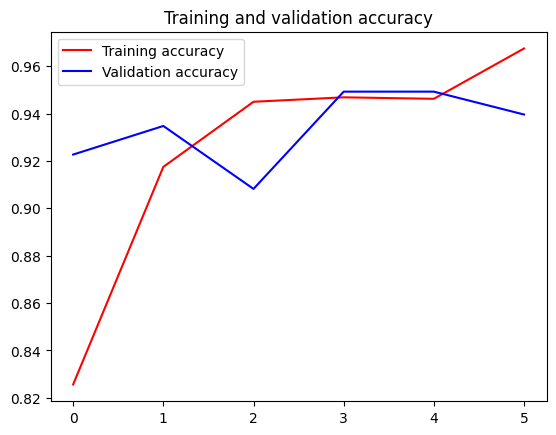

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# Testing the model

In [20]:
# Unzipping the zip files
train_local_zip = '/content/test-images.zip'
zip_ref = zipfile.ZipFile(train_local_zip, 'r')
zip_ref.extractall('test-images')

zip_ref.close()

# model.predict()

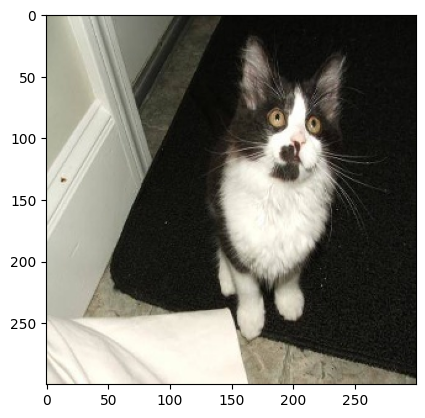

In [23]:
plt.imshow(load_img(f"{os.path.join(('/content/test-images/test-images/cat'), os.listdir('/content/test-images/test-images/cat')[0])}"))
plt.show()

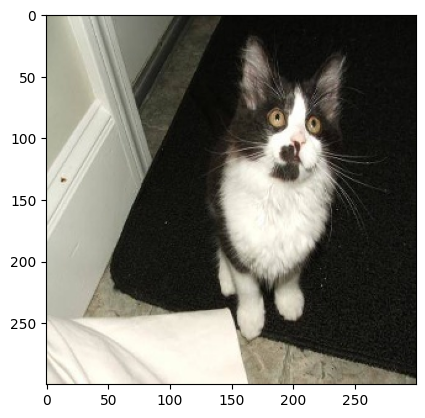

Each image has shape: (150, 150, 3)


In [34]:
test_image = os.path.join(('/content/test-images/test-images/cat'), os.listdir('/content/test-images/test-images/cat')[0])
# Load the first example of a horse
sample_image_test  = load_img(f"{test_image}", target_size=(150, 150))

plt.imshow(load_img(f"{test_image}"))
plt.show()

# Convert the image into its numpy array representation
sample_array_test = img_to_array(sample_image_test) / 255.0

print(f"Each image has shape: {sample_array_test.shape}")

In [38]:
import numpy as np

# Initialize an empty list to store the prediction results
prediction_results = []

for i in range(10):
    test_image = os.path.join(('/content/test-images/test-images/cat'), os.listdir('/content/test-images/test-images/cat')[i])
    sample_image_test = load_img(f"{test_image}", target_size=(150, 150))
    sample_array_test = img_to_array(sample_image_test) / 255.0

    # Make predictions and append the result to the list
    prediction = model.predict(sample_array_test[np.newaxis, ...])
    prediction_results.append(prediction)

# Print the list of prediction results
print(prediction_results)


1/1 [==============================] - 0s 25ms/step
[array([[9.064865e-05]], dtype=float32), array([[0.01547331]], dtype=float32), array([[1.6659204e-05]], dtype=float32), array([[1.2619861e-08]], dtype=float32), array([[8.676301e-05]], dtype=float32), array([[2.2607328e-07]], dtype=float32), array([[2.7110764e-05]], dtype=float32), array([[2.7001961e-05]], dtype=float32), array([[0.00020247]], dtype=float32), array([[0.02317255]], dtype=float32)]


In [41]:
import numpy as np

# Initialize an empty list to store the prediction results
prediction_results = []

for i in range(5):
    test_image = os.path.join(('/content/test-images/test-images/rabbit'), os.listdir('/content/test-images/test-images/rabbit')[i])
    sample_image_test = load_img(f"{test_image}", target_size=(150, 150))
    sample_array_test = img_to_array(sample_image_test) / 255.0

    # Make predictions and append the result to the list
    prediction = model.predict(sample_array_test[np.newaxis, ...])
    prediction_results.append(prediction)

# Print the list of prediction results
print(prediction_results)


1/1 [==============================] - 0s 41ms/step
[array([[0.99996257]], dtype=float32), array([[0.9999713]], dtype=float32), array([[0.99999917]], dtype=float32), array([[0.99999774]], dtype=float32), array([[0.9659273]], dtype=float32)]


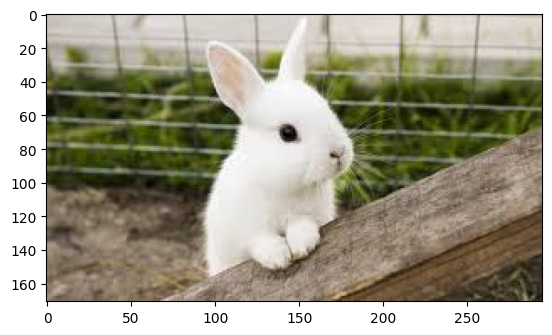

In [46]:
test_image = os.path.join(('/content/test-images/test-images/rabbit'), os.listdir('/content/test-images/test-images/rabbit')[3])
# Load the first example of a horse
sample_image_test  = load_img(f"{test_image}", target_size=(150, 150))

plt.imshow(load_img(f"{test_image}"))
plt.show()


# Finished...